In [1]:
import demo_util
import numpy as np
import torch

from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download
from modeling.maskgit import ImageBert
from modeling.titok import TiTok

attention mode is flash
attention mode is flash


In [2]:
# load the pretrained models from huggingface
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")

In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(0)

## Prepare the TiTok models

In [3]:
config = demo_util.get_config("configs/titok_s128.yaml")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tannicholas/SLT_FYP/final_product/vis_tokenizer/configs/titok_s128.yaml'

In [8]:
print(config)

{'experiment': {'tokenizer_checkpoint': 'tokenizer_titok_s128.bin', 'generator_checkpoint': 'generator_titok_s128.bin', 'output_dir': 'titok_s_128'}, 'model': {'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'small', 'vit_dec_model_size': 'small', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 128, 'finetune_decoder': True}, 'generator': {'model_type': 'UViT', 'hidden_size': 1024, 'num_hidden_layers': 20, 'num_attention_heads': 16, 'intermediate_size': 4096, 'dropout': 0.1, 'attn_drop': 0.1, 'num_steps': 64, 'mask_schedule_strategy': 'arccos', 'class_label_dropout': 0.1, 'image_seq_len': '${model.vq_model.num_latent_tokens}', 'condition_num_classes': 1000, 'randomize_temperature': 2.8, 'guidance_scale': 6.9, 'guidance_decay': 'power-cosine'}}, 'dataset': {'preprocessing': {'crop_size': 256}}}


In [9]:
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
titok_tokenizer.eval()
titok_tokenizer.requires_grad_(False)
# or alternatively, downloads from hf

# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# titok_tokenizer = demo_util.get_titok_tokenizer(config)

print(titok_tokenizer)

TiTok(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-23): 24 x ResidualAttentionBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(1024, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decoder_embed): Linear(in_features=12, out_

In [10]:
# supported generator: [generator_titok_l32_imagenet, generator_titok_b64_imagenet, generator_titok_s128_imagenet]
titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_s128_imagenet")
titok_generator.eval()
titok_generator.requires_grad_(False)

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")
# titok_generator = demo_util.get_titok_generator(config)
print(titok_generator)

ImageBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5098, 1024)
      (position_embeddings): Embedding(129, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-19): 20 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affin

In [34]:
device = "cpu"
titok_tokenizer = titok_tokenizer.to(device)
titok_generator = titok_generator.to(device)

## Tokenize and Reconstruct an image with 32 discrete tokens

In [53]:
# Tokenize an Image into 32 discrete tokens
print(device)
def tokenize_and_reconstruct(img_path):
    crop_width = 410
    image = Image.open(img_path)
    

    # Crop the image based on the provided config (center horizontal, lower vertical crop).
    x_start = int((image.size[0] - crop_width) // 2)
    x_end = x_start + crop_width
    y_start = image.size[1] - crop_width
    y_end = image.size[1]
    image = image.crop((x_start, y_start, x_end, y_end))
    # Normalize the image to ImageNet values
    image = torch.from_numpy(np.array(image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    image = torch.nn.functional.interpolate(image, size=(256, 256), mode='bilinear', align_corners=False)
    image = image.to(device)
    
    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    print("orginal image:")
    display(image)
    print("reconstructed image:")
    display(reconstructed_image)

cpu


Input Image is represented by codes tensor([[[2160, 2035, 1829,  638,   38, 3977, 3629,  887, 1666, 3648, 1794,
          1682, 3258,  673,  151,  595, 2783, 3868, 3494, 2220, 3745, 1881,
          2565, 2838, 1006, 1132, 2942,  548, 1708, 1221, 2577, 2094]]]) with shape torch.Size([1, 1, 32])
orginal image:


tensor([[[[0.9059, 0.9059, 0.9137,  ..., 0.9230, 0.9218, 0.9243],
          [0.9069, 0.9094, 0.9137,  ..., 0.9216, 0.9216, 0.9216],
          [0.9077, 0.9118, 0.9137,  ..., 0.9255, 0.9253, 0.9235],
          ...,
          [0.7855, 0.7900, 0.7922,  ..., 0.7098, 0.7098, 0.7043],
          [0.7797, 0.7871, 0.7879,  ..., 0.7116, 0.7098, 0.7043],
          [0.7765, 0.7765, 0.7843,  ..., 0.7084, 0.7093, 0.7027]],

         [[0.9098, 0.9098, 0.9137,  ..., 0.9190, 0.9179, 0.9204],
          [0.9109, 0.9133, 0.9137,  ..., 0.9176, 0.9176, 0.9176],
          [0.9110, 0.9137, 0.9137,  ..., 0.9216, 0.9214, 0.9196],
          ...,
          [0.7596, 0.7586, 0.7608,  ..., 0.6921, 0.6961, 0.6974],
          [0.7569, 0.7569, 0.7565,  ..., 0.6920, 0.6980, 0.6983],
          [0.7569, 0.7569, 0.7529,  ..., 0.6888, 0.6980, 0.7008]],

         [[0.8784, 0.8784, 0.8824,  ..., 0.9033, 0.9022, 0.9047],
          [0.8795, 0.8820, 0.8824,  ..., 0.8984, 0.8984, 0.8984],
          [0.8796, 0.8824, 0.8824,  ..., 0

reconstructed image:


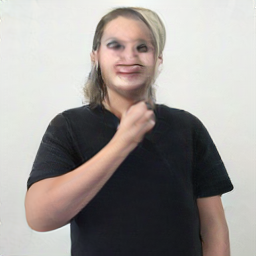

In [54]:
tokenize_and_reconstruct("assets/000004.jpg")

Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774, 2296,  484, 2612, 3472, 2330, 3140, 3113,
          1056, 3779,  654, 2360, 1901, 2908, 2169,  953, 1326, 2598]]]) with shape torch.Size([1, 1, 32])
orginal image:


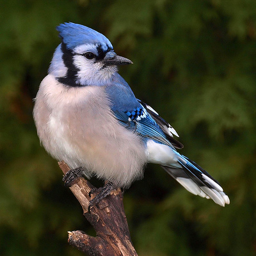

reconstructed image:


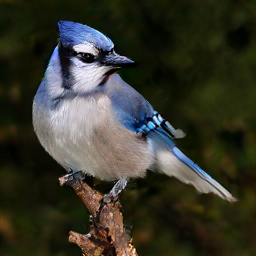

In [37]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")

## Generate an image from 32 discrete tokens

In [ ]:
sample_labels = [torch.randint(0, 999, size=(1,)).item()]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=titok_generator,
    tokenizer=titok_tokenizer,
    labels=sample_labels,
    guidance_scale=3.5,
    randomize_temperature=1.0,
    num_sample_steps=8,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))

NameError: name 'titok_generator' is not defined